In [1]:
# Fix for issue loading Utils.preprocess_util
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import torch
import torch.nn as nn
import torch.optim  as optim
from torch.autograd import Variable
from Utils.preprocess_util import *
from Utils.visualize import *
import torch.utils.data
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2


In [ ]:
X_train,X_valid,X_test,Y_train,Y_valid,Y_test = load_preprocess_eeg_data()


(2115, 22, 1000)
Cropping trials


In [12]:
indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=False)
X_train = X_train[indices]
Y_train = Y_train[indices]


In [13]:
indices = np.random.choice(X_valid.shape[0], X_valid.shape[0], replace=False)
X_valid = X_valid[indices]
Y_valid = Y_valid[indices]

indices = np.random.choice(X_test.shape[0], X_test.shape[0], replace=False)
X_test = X_test[indices]
Y_test = Y_test[indices]

In [ ]:
# create feature and targets tensor for train set
features_train = torch.from_numpy(X_train)
targets_train = torch.from_numpy(Y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set
features_test = torch.from_numpy(X_test)
targets_test = torch.from_numpy(Y_test).type(torch.LongTensor)

features_valid = torch.from_numpy(X_valid)
targets_valid = torch.from_numpy(Y_valid).type(torch.LongTensor)

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        a= x.view(x.size(0), -1)
        return a
    
class threed_to_twod(nn.Module):
    def forward(self, x):
        # print(x.shape)
        a = x.reshape(x.shape[0],x.shape[3],x.shape[1])
        print ("a=",a.shape)
        return a

class permute(nn.Module):
    def forward(self, x):
        # print(x.shape)
        a = x.permute(1, 0, 2) 
        #print ("a=",a.shape)
        return a
        #,((torch.zeros(num_layers, batch_size, n_neurons)),(torch.zeros(num_layers, batch_size, n_neurons)))

class get_hidden(nn.Module):
    def forward(self, x):
        #print(x.shape)
        lstm_out, (hidden, cellstate) = x  
        print ("hidden=",hidden.shape)
        return hidden

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs,n_layers,droput):
        super(LSTMModel, self).__init__()
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.num_layers = n_layers
        self.cnn1 = nn.Conv2d(1,40,kernel_size=(1,51),stride = 1)
        self.cnn2= nn.Conv2d(40,40,kernel_size=(22,1),stride = 1)
        self.batchnorm= nn.BatchNorm2d(40,momentum=0.1)
        self.relu = nn.ReLU()
        self.threed_to_twod = threed_to_twod()
        self.avgpool2d =  nn.AvgPool2d(kernel_size=(1,135),stride = (1,5))
        self.dropout =  nn.Dropout(p=droput)
        self.lstm = nn.LSTM(self.n_inputs, self.n_neurons,self.num_layers) 
        #self.lstm.weight_hh_l0.data.fill_(0)
        #torch.nn.init.xavier_uniform_(self.lstm.weight_ih_l0.data )
        #torch.nn.init.orthogonal_(self.lstm.weight_hh_l0.data)
        
        torch.nn.init.xavier_uniform_(self.cnn1.weight, gain=1)
        torch.nn.init.xavier_uniform_(self.cnn2.weight, gain=1)

        
        #initialising w(rec) to I and b(rec) to 0 
        ih_size = list(self.lstm.weight_ih_l0.data.shape)
        hh_size =list(self.lstm.weight_hh_l0.data.shape)
        self.lstm.weight_ih_l0.data.copy_(torch.eye(ih_size[0],ih_size[1]))
        self.lstm.weight_hh_l0.data.copy_(torch.eye(hh_size[0],hh_size[1]))
        
        self.lstm.bias_ih_l0.data.fill_(0)
        self.lstm.bias_hh_l0.data.fill_(0)
        
        self.droput = nn.Dropout(p=droput)
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
            # (num_layers, batch_size, n_neurons)
            return (torch.zeros(self.num_layers, self.batch_size, self.n_neurons))
            #return torch.nn.init.xavier_uniform_((self.num_layers, self.batch_size, self.n_neurons), gain=1)

    def forward(self, X):
            # transforms X to (n_steps, batch_size, n_inputs0
            conv_out1 = self.cnn1(X)
            conv_out2 = self.cnn2(conv_out1)
            batchnorm_out = self.batchnorm(conv_out2)
            relu_out = self.relu(batchnorm_out)
            AvgPool2d_out = self.avgpool2d(relu_out)
            drop_out = self.dropout(AvgPool2d_out)
            # transforms X to (n_steps, batch_size, n_inputs)
            X_new = drop_out.view(drop_out.shape[0],drop_out.shape[1],drop_out.shape[3])  
            X_new = X_new.permute(2, 0, 1) 
            self.batch_size = X_new.size(1)
            self.hidden = self.init_hidden()
            self.cellstate = self.init_hidden()
            #torch.nn.init.xavier_uniform_(self.hidden)
            #torch.nn.init.xavier_uniform_(self.cellstate)
            lstm_out, (self.hidden, self.cellstate)= self.lstm(X_new, (self.hidden,self.cellstate))
            hidden_out =self.hidden[self.num_layers-1]
            dropout_out = self.droput(hidden_out)
            out = self.FC(dropout_out)

            return out.view(-1, self.n_outputs) # (batch_size, n_output)


In [96]:
batch_size = 100
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(features_train, targets_train)
valid = torch.utils.data.TensorDataset(features_valid, targets_valid)
test = torch.utils.data.TensorDataset(features_test, targets_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

# pprint.pprint(test_loader.dataset.tensors[0].size())

In [97]:
N_STEPS = 500
N_INPUTS = 40
N_NEURONS = 75
N_OUTPUTS = 10
N_EPOCHS = 10
N_LAYERS = 1# This actually corresponds to how many lsts are stacked one above the other
droput = 0
dataiter = iter(train_loader)
signals, labels = dataiter.next()
model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS,droput)

signals_modified= threeD_to_fourDTensor(signals)
print(signals_modified.shape)
logits = model(signals_modified.float())
print(logits[0:10])

torch.Size([100, 1, 22, 500])
tensor([[ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587, -0.0742],
        [ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587, -0.0742],
        [ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587, -0.0742],
        [ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587, -0.0742],
        [ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587, -0.0742],
        [ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587, -0.0742],
        [ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587, -0.0742],
        [ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587, -0.0742],
        [ 0.0824,  0.0064, -0.0598, -0.1094,  0.0085,  0.0768,  0.0037,  0.0598,
         -0.0587,

In [100]:
dtype = torch.FloatTensor
n_iters = 10000
num_epochs = int(n_iters / (len(X_train)/batch_size))
model = LSTMModel(batch_size, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS,N_LAYERS,droput)

# Cross Entropy Loss 
loss_fn = nn.CrossEntropyLoss().type(dtype)

# batch GD
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

train_loss = []
iterations = []
train_acc = []

#X_valid_tensor = threeD_to_fourDTensor(X_valid)
#X_train_tensor = threeD_to_fourDTensor(X_train)

#print("X=",X_train_tensor.shape)
print("num_epochs = ", num_epochs)
print("n_iters = ", n_iters)
print("starting training..")

num_train = X_train.shape[0]
num_valid = X_valid.shape[0]
batch_size = 100

count = 0
num_epochs = 2
print("starting training..")
for t in range(num_iterations):
        batch_mask = np.random.choice(num_train, batch_size,replace = False)
        X_batch = X_train[batch_mask]
        y_batch = Y_train[batch_mask]
        X_batch_tensor = threeD_to_fourDTensor(X_batch)
        y_batch_tensor = Variable(torch.tensor(y_batch))

        y_pred = model( X_batch_tensor.float())                
        
                
        # Calculate softmax and cross entropy loss
        loss = loss_fn(y_pred,y_batch_tensor.type(torch.LongTensor))
              
        model.zero_grad()
        loss.backward()
        optimizer.step()
                    
        #print("parameters===",list(model.parameters())[0].data)

        count += 1
        train_loss.append(loss.data)
        iterations.append(count)
        if count % 1 == 0:
                X_train_tensor =threeD_to_fourDTensor(X_train[0:100,:,:])
                y_pred_train = model( X_train_tensor.float())
                train_acc = get_accuracy(y_pred_train, Y_train[0:100],
                    batch_size=100)

                X_valid_tensor = threeD_to_fourDTensor(X_valid[0:100,:,:])
                y_pred_valid = model( X_valid_tensor.float())
                val_acc = get_accuracy(y_pred_valid, Y_valid[0:100],
                    batch_size=100)
                
                print('Iteration: {}  Loss: {}  Train Accuracy: {} Valid Accuracy: {} %'.format(count, loss.data,train_acc,
                                                                                            val_acc))

num_epochs =  5
n_iters =  10000
starting training..
starting training..
Iteration: 1  Loss: 2.304326057434082  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 2  Loss: 2.3020730018615723  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 3  Loss: 2.289412498474121  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 4  Loss: 2.2851216793060303  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 5  Loss: 2.284088373184204  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 6  Loss: 2.2670066356658936  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 7  Loss: 2.2701377868652344  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 8  Loss: 2.2426254749298096  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 9  Loss: 2.2545735836029053  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 10  Loss: 2.2223055362701416  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 11  Loss: 2.218129873275757  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Itera

Iteration: 98  Loss: 1.4770786762237549  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 99  Loss: 1.49336576461792  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 100  Loss: 1.4775999784469604  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 101  Loss: 1.4696277379989624  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 102  Loss: 1.4721336364746094  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 103  Loss: 1.4697860479354858  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 104  Loss: 1.4696931838989258  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 105  Loss: 1.4641621112823486  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 106  Loss: 1.458518385887146  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 107  Loss: 1.4696862697601318  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 108  Loss: 1.4595115184783936  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 109  Loss: 1.459538221359253  Train Accuracy: 32

Iteration: 194  Loss: 1.4007530212402344  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 195  Loss: 1.4133384227752686  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 196  Loss: 1.4023045301437378  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 197  Loss: 1.403874158859253  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 198  Loss: 1.4014315605163574  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 199  Loss: 1.4000166654586792  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 200  Loss: 1.4030815362930298  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 201  Loss: 1.4028164148330688  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 202  Loss: 1.3967251777648926  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 203  Loss: 1.3978402614593506  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 204  Loss: 1.4012694358825684  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 205  Loss: 1.3869317770004272  Train Accurac

Iteration: 290  Loss: 1.4043142795562744  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 291  Loss: 1.3871876001358032  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 292  Loss: 1.3874008655548096  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 293  Loss: 1.4049818515777588  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 294  Loss: 1.4027214050292969  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 295  Loss: 1.3907406330108643  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 296  Loss: 1.3883028030395508  Train Accuracy: 30.0 Valid Accuracy: 22.0 %
Iteration: 297  Loss: 1.4024717807769775  Train Accuracy: 29.0 Valid Accuracy: 25.0 %
Iteration: 298  Loss: 1.3908989429473877  Train Accuracy: 28.0 Valid Accuracy: 24.0 %
Iteration: 299  Loss: 1.395440697669983  Train Accuracy: 30.0 Valid Accuracy: 25.0 %
Iteration: 300  Loss: 1.3861552476882935  Train Accuracy: 29.0 Valid Accuracy: 20.0 %
Iteration: 301  Loss: 1.3966412544250488  Train Accurac

Iteration: 386  Loss: 1.3978962898254395  Train Accuracy: 19.0 Valid Accuracy: 26.0 %
Iteration: 387  Loss: 1.3896484375  Train Accuracy: 19.0 Valid Accuracy: 26.0 %
Iteration: 388  Loss: 1.3974193334579468  Train Accuracy: 19.0 Valid Accuracy: 26.0 %
Iteration: 389  Loss: 1.3935034275054932  Train Accuracy: 21.0 Valid Accuracy: 27.0 %
Iteration: 390  Loss: 1.3912581205368042  Train Accuracy: 21.0 Valid Accuracy: 27.0 %
Iteration: 391  Loss: 1.3913530111312866  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 392  Loss: 1.3929715156555176  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 393  Loss: 1.3932706117630005  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 394  Loss: 1.3914293050765991  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 395  Loss: 1.3932284116744995  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 396  Loss: 1.3903858661651611  Train Accuracy: 32.0 Valid Accuracy: 21.0 %
Iteration: 397  Loss: 1.3913935422897339  Train Accuracy: 32

KeyboardInterrupt: 

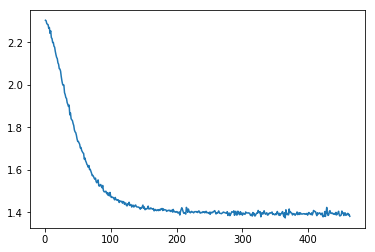

In [101]:
import matplotlib.pyplot as plt
plt.plot(iterations,train_loss)
plt.show();